## Config

In [47]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import qgrid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## GDAX

In [48]:
# https://github.com/danpaquin/gdax-python
# https://docs.gdax.com

# Use the sandbox API (requires a different set of API access credentials)
gdax_client = gdax.AuthenticatedClient(cfg.GDAX_API_KEY, cfg.GDAX_API_SECRET_KEY, 
                                       cfg.GDAX_PASSPHRASE, api_url=cfg.GDAX_ENDPOINT)
gdax_client.get_time()

{'epoch': 1514739487.425, 'iso': '2017-12-31T16:58:07.425Z'}

### Historical Prices

In [39]:
# Default request is 400 minutes (~7 hours), 1 minute gap
# ~4 requests to get 24 hours of data
# 1460 requests for 1 year, ~3000 requests for 2 years

START_UTC = '2015-01-01T00:00:00Z'
END_UTC = '2017-12-31T00:00:00Z'
BTC_PRICE_FPATH = os.path.join(cfg.DATA_DIR, 'gdax_btc_price.csv')
PRICE_COLUMNS = ['time', 'low', 'high', 'open', 'close', 'volume']

def write_to_df(data, fpath):
    if os.path.exists(fpath):
        df = pd.read_csv(fpath)
        data = pd.DataFrame(data, columns=PRICE_COLUMNS)
        df.set_index('time')
        df = df.sort_values(by='time', ascending=True)
        df = pd.concat([df, data]).drop_duplicates().reset_index(drop=True)
    else:
        df = pd.DataFrame(data, columns=PRICE_COLUMNS)
        df.set_index('time')
        df = df.sort_values(by='time', ascending=True)
    df.to_csv(fpath, index=False)
    return df

def get_data(currency_pair, start_time, end_time, timestep_sec):
#     print("Start", start_utc.isoformat())
#     print("End", end_utc.isoformat())
    delta = end_time - start_time
#     print("Years", round(delta.days/365,2))
#     print("Days", delta.days)
#     print("Hours", delta.days*24)
#     print("Minutes", delta.days*24*60)
#     print("Seconds", round(delta.total_seconds()))
    data = gdax_client.get_product_historic_rates(
        currency_pair, start=start_time.isoformat(), 
        end=end_time.isoformat(), granularity=timestep_sec)
    return data

def get_all_data(pair, start_utc, end_utc, timesteps_per_request, timestep_sec, outfpath):
    start_time = datetime.datetime.strptime(
        start_utc, '%Y-%m-%dT%H:%M:%SZ')#.astimezone(datetime.timezone.utc)
    end_time = datetime.datetime.strptime(
        end_utc, '%Y-%m-%dT%H:%M:%SZ')#.astimezone(datetime.timezone.utc)
    cur_time = start_time
    print("Start", cur_time)
    print("End", end_time)
    time_delta = datetime.timedelta(
        seconds=timesteps_per_request*timestep_sec)
    n_records = 0
    retry = 0
    while cur_time < end_time and retry < 10:
        try:
            data = get_data(pair, cur_time, cur_time+time_delta, timestep_sec)
            data = np.array(data)
            last_time = datetime.datetime.fromtimestamp(np.max(data[:,0]))
            if last_time < cur_time:
                break
            print("Records", n_records, "Start:", cur_time, "End:", last_time)
            cur_time = datetime.datetime.fromtimestamp(
                data[0][0] + timestep_sec)
            df = write_to_df(data, outfpath)
            n_records += len(data)
            retry = 0
        except Exception as e:
            retry += 1
            print("Error", e)
            traceback.print_exc()
        finally:
            time.sleep(1)
    return df

In [40]:
df = get_all_data(c.BTC_USD, START_UTC, END_UTC, 200, 3600, BTC_PRICE_FPATH)

Start 2015-01-01 00:00:00
End 2017-12-31 00:00:00
Records 0 Start: 2015-01-01 00:00:00 End: 2015-01-08 12:00:00
Records 9 Start: 2015-01-08 13:00:00 End: 2015-01-15 19:00:00
Records 35 Start: 2015-01-15 20:00:00 End: 2015-01-23 16:00:00
Records 62 Start: 2015-01-23 17:00:00 End: 2015-01-31 16:00:00
Records 229 Start: 2015-01-31 17:00:00 End: 2015-02-08 16:00:00
Records 429 Start: 2015-02-08 17:00:00 End: 2015-02-16 16:00:00
Records 629 Start: 2015-02-16 17:00:00 End: 2015-02-24 16:00:00
Records 829 Start: 2015-02-24 17:00:00 End: 2015-03-04 16:00:00
Records 1029 Start: 2015-03-04 17:00:00 End: 2015-03-12 17:00:00
Records 1229 Start: 2015-03-12 18:00:00 End: 2015-03-20 18:00:00
Records 1429 Start: 2015-03-20 19:00:00 End: 2015-03-28 19:00:00
Records 1629 Start: 2015-03-28 20:00:00 End: 2015-04-05 20:00:00
Records 1829 Start: 2015-04-05 21:00:00 End: 2015-04-13 21:00:00
Records 2029 Start: 2015-04-13 22:00:00 End: 2015-04-21 22:00:00
Records 2229 Start: 2015-04-21 23:00:00 End: 2015-04-2

Records 24415 Start: 2017-09-29 07:00:00 End: 2017-10-07 07:00:00
Records 24615 Start: 2017-10-07 08:00:00 End: 2017-10-15 08:00:00
Records 24815 Start: 2017-10-15 09:00:00 End: 2017-10-23 09:00:00
Records 25015 Start: 2017-10-23 10:00:00 End: 2017-10-31 10:00:00
Records 25215 Start: 2017-10-31 11:00:00 End: 2017-11-08 10:00:00
Records 25415 Start: 2017-11-08 11:00:00 End: 2017-11-16 10:00:00
Records 25615 Start: 2017-11-16 11:00:00 End: 2017-11-24 10:00:00
Records 25815 Start: 2017-11-24 11:00:00 End: 2017-12-02 10:00:00
Records 26014 Start: 2017-12-02 11:00:00 End: 2017-12-10 10:00:00
Records 26214 Start: 2017-12-10 11:00:00 End: 2017-12-18 10:00:00
Records 26413 Start: 2017-12-18 11:00:00 End: 2017-12-26 10:00:00
Records 26613 Start: 2017-12-26 11:00:00 End: 2017-12-30 22:00:00


In [12]:
start_utc = '2015-01-01T00:00:00Z'
end_utc = '2017-12-31T00:00:00Z'
df = get_all_data(c.BTC_USD, start_utc, end_utc, 400, 900, BTC_PRICE_FPATH)

In [25]:
s = datetime.datetime.fromtimestamp(1514641260)
next_ = datetime.datetime.fromtimestamp(1514641320)
e = datetime.datetime.fromtimestamp(1514665260)
s,next_,e,len(prices),(e-s).total_seconds()/3600
#datetime.datetime.timestamp(s)

(datetime.datetime(2017, 12, 30, 5, 41),
 datetime.datetime(2017, 12, 30, 5, 42),
 datetime.datetime(2017, 12, 30, 12, 21),
 401,
 6.666666666666667)

### Load Prices

In [41]:
# https://github.com/bfortuner/computer-vision/blob/master/applied/libraries/PandasQuickstart.ipynb
df = pd.read_csv(BTC_PRICE_FPATH)
epochsec = [datetime.datetime.fromtimestamp(t) for t in df['time'].values]
df = df.assign(time_utc = epochsec)

In [42]:
len(df)

25956

In [43]:
# Check for NULL
df.isnull().sum()

time        0
low         0
high        0
open        0
close       0
volume      0
time_utc    0
dtype: int64

In [44]:
last_time = df.iloc[-1]['time']
last_record_utc = datetime.datetime.fromtimestamp(last_time)
print(last_record_utc.isoformat())
df.describe()
df.head()

2017-12-14T06:00:00


,time,low,high,open,close,volume,time_utc
0,1.420679e+09,270.35,360.00,360.00,283.25,0.79,2015-01-07 17:00:00
1,1.420682e+09,269.06,348.43,334.27,271.84,1.46,2015-01-07 18:00:00
2,1.420686e+09,268.26,314.74,284.11,285.88,1.40,2015-01-07 19:00:00
3,1.420690e+09,264.81,314.85,288.06,307.57,1.27,2015-01-07 20:00:00
4,1.420693e+09,265.51,314.96,314.96,275.44,1.44,2015-01-07 21:00:00


In [45]:
# Query Date Range
start = datetime.datetime(2017, 4, 15, 12, 0)
end = datetime.datetime(2017, 4, 15, 16, 10)
results = df[ (df['time_utc'] >= start) & (df['time_utc'] < end) ]

In [46]:
# Check for missing timesteps
last_time = df.iloc[0]['time_utc']
n_missing = 0
for idx,row in df[1:].iterrows():
    cur_time = row['time_utc']
#     print(cur_time, last_time + datetime.timedelta(seconds=60))
    if cur_time != last_time + datetime.timedelta(seconds=3600):
        n_missing += 1 #(cur_time - last_time).seconds//60
    last_time = cur_time
n_missing

368

### Plot

In [35]:
# https://github.com/quantopian/qgrid
# https://hub.mybinder.org/user/quantopian-qgrid-notebooks-bu5joi0d/notebooks/index.ipynb
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html

qgrid_widget = qgrid.QgridWidget(df=df, show_toolbar=True)
qgrid_widget
#qgrid_widget.get_changed_df()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8}, precision=5, show_toolbar=True)

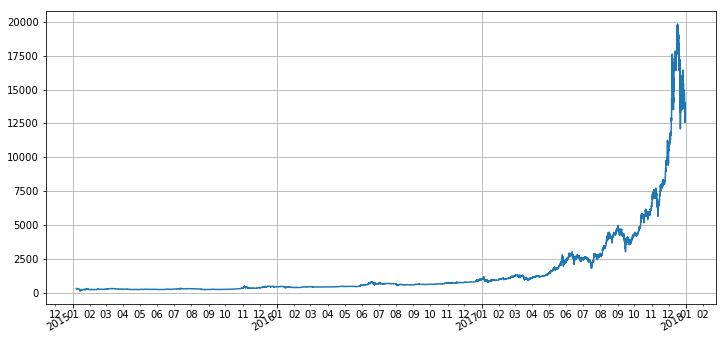

In [36]:
def plot_prices(time, close):
    fig, ax = plt.subplots()
    ax.plot(time, close)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    monthsFmt = mdates.DateFormatter('%m')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)

    # datemin = datetime.date(r.date.min().year, 1, 1)
    # datemax = datetime.date(r.date.max().year + 1, 1, 1)
    # ax.set_xlim(datemin, datemax)

    # # format the coords message box
    # def price(x):
    #     return '$%1.2f' % x
    # ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = price
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate(rotation=30)
    fig.set_size_inches(12,6)
    plt.show()

def plot_range(df, start, end):
    df = df[ (df['time_utc'] >= start) & (df['time_utc'] < end) ]
    vals = df[['time_utc','close']].values
    plot_prices(vals[:,0], vals[:,1])

vals = df[['time_utc','close']].values
plot_prices(vals[:,0], vals[:,1])
# start = datetime.datetime(2017, 4, 15, 12, 0)
# end = datetime.datetime(2017, 4, 15, 16, 10)
# results = df[ (df['time_utc'] >= start) & (df['time_utc'] < end) ]
# results = results.drop(684239)
# plot_range(results, start, end)

### Exchange Metadata

In [ ]:
gdax_client.get_products()
gdax_client.get_currencies()
gdax_client.get_time()

### Current Prices

In [ ]:
# Get the order book at the default level.
gdax_client.get_product_order_book('BTC-USD')
# Get the order book at a specific level.
gdax_client.get_product_order_book('BTC-USD', level=1)

In [ ]:
# Get the product ticker for a specific product.
gdax_client.get_product_ticker(product_id='ETH-USD')

In [ ]:
# Get the product trades for a specific product.
gdax_client.get_product_trades(product_id='ETH-USD')

In [ ]:
gdax_client.get_product_24hr_stats('ETH-USD')

### Streaming

In [ ]:
class myWebsocketClient(gdax.WebsocketClient):
    def on_open(self):
        self.url = cfg.GDAX_WEBSOCKET
        self.products = [c.BTC_USD]
        self.message_count = 0
        print("Lets count the messages!")
    
    def on_message(self, msg):
        self.message_count += 1
        if 'price' in msg and 'type' in msg:
            print ("Message type:", msg["type"],
                   "\t@ {:.3f}".format(float(msg["price"])))
    
    def on_close(self):
        print("-- Goodbye! --")

        
wsClient = myWebsocketClient()
wsClient.start()
print(wsClient.url, wsClient.products)
while (wsClient.message_count < 500):
    print ("\nmessage_count =", "{} \n".format(wsClient.message_count))
    time.sleep(1)
wsClient.close()

In [ ]:
wsClient.close()